# Record Disambiguation

In this notebook we perform entity disambiguation on records, specifically person records.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

import sys
sys.path.append("..")

from heritageconnector.disambiguation.helpers import load_training_data, plot_performance_curves, filter_top_ranked_results
from heritageconnector.disambiguation.pipelines import Disambiguator
from heritageconnector.utils.wikidata import get_sparql_results, url_to_qid
from heritageconnector.utils.generic import paginate_list
from heritageconnector.config import config

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

## 1. Load data
This data has already been generated using `Disambiguator.save_training_data_to_folder` and `Disambiguator.save_test_data_to_folder`.

In [2]:
train_dir = "/Volumes/Kalyan_SSD/SMG/disambiguation/organisations_021120/train/"
test_dir = "/Volumes/Kalyan_SSD/SMG/disambiguation/organisations_021120/test/"

In [3]:
X, y, pairs, pids = load_training_data(train_dir)
X_new, pairs_new, pids_new = load_training_data(test_dir)

In [4]:
pids, pids_new

(['P571', 'P17', 'P576', 'label', 'P31'],
 ['P571', 'P17', 'P576', 'label', 'P31'])

In [5]:
X.sum(axis=0), X_new.sum(axis=0)

(array([ 2065.43552665,  3650.00001308,   390.65041494, 10510.98999181,
         1882.37945545]),
 array([ 7077.69297345, 21222.44011462,   871.75777721, 87865.52991133,
        12582.58693225]))

In [6]:
pairs.head()

,internal_id,wikidata_id,is_type
0,https://collection.sciencemuseumgroup.org.uk/people/cp160635,Q5412030,True
1,https://collection.sciencemuseumgroup.org.uk/people/cp160635,Q643519,True
2,https://collection.sciencemuseumgroup.org.uk/people/cp160635,Q8591063,True
3,https://collection.sciencemuseumgroup.org.uk/people/cp160635,Q60895350,True
4,https://collection.sciencemuseumgroup.org.uk/people/cp160635,Q1025696,True


## 2. Train classifier
The disambiguator wraps `sklearn.tree.DecisionTreeClassifier` and takes its parameters as inputs.

### 2a. Test classifier performance
We'll perform a train/test split on the labelled data to quickly test the classifier's performance using its `score` method. 

The `score` method here returns [balanced accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html): accuracy weighted so that each class is considered evenly.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [8]:
clf = Disambiguator('ORGANISATION', max_depth=6).fit(X_train, y_train)
for threshold in [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]:
    print(str(threshold) + " --- \n" + clf.score(X_test, y_test, threshold))

0.5 --- 
balanced accuracy score: 0.8973468811741463
precision score: 0.3795620437956204
recall score: 0.8666666666666667
0.6 --- 
balanced accuracy score: 0.8973468811741463
precision score: 0.3795620437956204
recall score: 0.8666666666666667
0.7 --- 
balanced accuracy score: 0.8998871013265595
precision score: 0.3969465648854962
recall score: 0.8666666666666667
0.8 --- 
balanced accuracy score: 0.8953640982218458
precision score: 0.4214876033057851
recall score: 0.85
0.9 --- 
balanced accuracy score: 0.8580651989839119
precision score: 0.5294117647058824
recall score: 0.75
0.95 --- 
balanced accuracy score: 0.6899731865650579
precision score: 0.8518518518518519
recall score: 0.38333333333333336


### 2b. Use classifier to predict new Wikidata links

In [9]:
clf = Disambiguator('ORGANISATION', max_depth=6).fit(X, y)
y_pred = clf.predict(X_new, threshold=0.95)
y_pred_proba = clf.predict_proba(X_new)

print(f"{np.unique(y_pred, return_counts=True)[1][1]} potential new links found")

1227 potential new links found


In [10]:
pairs_new["y_pred"] = y_pred
pairs_new["y_pred_proba"] = y_pred_proba

The graph below shows the distribution of the number of predicted matches per SMG ID. Around 75% have a unique match, and most of the remainder have two matches.

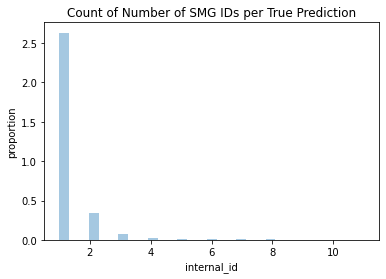

In [11]:
display(Markdown("The graph below shows the distribution of the number of predicted matches per SMG ID. Around 75% have a unique match, and most of the remainder have two matches."))
sns.distplot(pairs_new.loc[pairs_new["y_pred"] == True, "internal_id"].value_counts(), kde=False, norm_hist=True).set_ylabel('proportion')
plt.gca().set_title('Count of Number of SMG IDs per True Prediction');

## 2c. Returning top-ranked links only
We can filter some of the duplicate Wikidata candidates for each SMG item found above by _only returning the top-ranked positive matches_. `clf.predict_top_ranked_pairs` does this.

In [12]:
pairs_true = clf.predict_top_ranked_pairs(X_new, pairs_new, threshold=0.95)
print(f"No. new links: {len(pairs_true)}")
print(f"No. SMG items with new links: {len(pairs_true['internal_id'].unique())}")
pairs_true.head(20)

No. new links: 1143
No. SMG items with new links: 984


,internal_id,wikidata_id,is_type,y_pred,y_pred_proba
243,https://collection.sciencemuseumgroup.org.uk/people/cp67907,Q22268903,True,True,0.950553
279,https://collection.sciencemuseumgroup.org.uk/people/cp63077,Q46974,True,True,0.997054
861,https://collection.sciencemuseumgroup.org.uk/people/cp1208,Q27724422,True,True,0.950553
875,https://collection.sciencemuseumgroup.org.uk/people/cp92812,Q1419438,True,True,0.950553
967,https://collection.sciencemuseumgroup.org.uk/people/cp57931,Q2578470,True,True,0.950553
1088,https://collection.sciencemuseumgroup.org.uk/people/cp86959,Q5093779,True,True,0.950553
1226,https://collection.sciencemuseumgroup.org.uk/people/cp137175,Q1548575,True,True,0.950553
1255,https://collection.sciencemuseumgroup.org.uk/people/cp133059,Q88565690,True,True,0.992833
1350,https://collection.sciencemuseumgroup.org.uk/people/cp4558,Q1240510,True,True,0.992833
1361,https://collection.sciencemuseumgroup.org.uk/people/cp136764,Q908172,True,True,0.950553


## 2d. Filter matches

By type, number of links

In [13]:
max_links_per_record = 2
pairs_true_filtered = filter_top_ranked_results(pairs_true, enforce_correct_type=True, max_wikidata_links=max_links_per_record)

print("-- After Filtering --")
print(f"No. new links: {len(pairs_true_filtered)}")
print(f"No. SMG items with new links: {len(pairs_true_filtered['internal_id'].unique())}")

pairs_true_filtered.head(10)

-- After Filtering --
No. new links: 1023
No. SMG items with new links: 956


,internal_id,wikidata_id,is_type,y_pred,y_pred_proba
243,https://collection.sciencemuseumgroup.org.uk/people/cp67907,Q22268903,True,True,0.950553
279,https://collection.sciencemuseumgroup.org.uk/people/cp63077,Q46974,True,True,0.997054
861,https://collection.sciencemuseumgroup.org.uk/people/cp1208,Q27724422,True,True,0.950553
875,https://collection.sciencemuseumgroup.org.uk/people/cp92812,Q1419438,True,True,0.950553
967,https://collection.sciencemuseumgroup.org.uk/people/cp57931,Q2578470,True,True,0.950553
1088,https://collection.sciencemuseumgroup.org.uk/people/cp86959,Q5093779,True,True,0.950553
1226,https://collection.sciencemuseumgroup.org.uk/people/cp137175,Q1548575,True,True,0.950553
1255,https://collection.sciencemuseumgroup.org.uk/people/cp133059,Q88565690,True,True,0.992833
1350,https://collection.sciencemuseumgroup.org.uk/people/cp4558,Q1240510,True,True,0.992833
1361,https://collection.sciencemuseumgroup.org.uk/people/cp136764,Q908172,True,True,0.950553


## 3. Explain classifier
We can see that the classifier prioritises P569/P570 (birth and death dates), P21 (gender), label similarity, and occupation.

It's interesting to note that P31 (instance of), which tells the classifier whether the Wikidata record is a human, is not used. This is likely because P569/P570/P106/P21 are qualities which only humans can have.

P31 is likely to be much more prevalent when classifying objects, and distinguishing between e.g. paintings and posters.

In [14]:
clf.print_tree(feature_names=pids)

|--- P31 <= 0.15
|   |--- P571 <= 1.00
|   |   |--- label <= 0.93
|   |   |   |--- P17 <= 0.94
|   |   |   |   |--- class: False
|   |   |   |--- P17 >  0.94
|   |   |   |   |--- label <= 0.83
|   |   |   |   |   |--- P576 <= 0.39
|   |   |   |   |   |   |--- class: False
|   |   |   |   |   |--- P576 >  0.39
|   |   |   |   |   |   |--- class: False
|   |   |   |   |--- label >  0.83
|   |   |   |   |   |--- label <= 0.84
|   |   |   |   |   |   |--- class: False
|   |   |   |   |   |--- label >  0.84
|   |   |   |   |   |   |--- class: False
|   |   |--- label >  0.93
|   |   |   |--- P17 <= 0.62
|   |   |   |   |--- P571 <= 1.00
|   |   |   |   |   |--- label <= 0.99
|   |   |   |   |   |   |--- class: False
|   |   |   |   |   |--- label >  0.99
|   |   |   |   |   |   |--- class: False
|   |   |   |   |--- P571 >  1.00
|   |   |   |   |   |--- P17 <= 0.23
|   |   |   |   |   |   |--- class: False
|   |   |   |   |   |--- P17 >  0.23
|   |   |   |   |   |   |--- class: True
|   |  

## 4. Export model & sample of predictions

In [15]:
clf.save_classifier_to_disk("/Volumes/Kalyan_SSD/SMG/disambiguation/organisations_021120/clf.pkl")
pairs_true_filtered.to_csv("/Volumes/Kalyan_SSD/SMG/disambiguation/organisations_021120/orgs_preds_positive.csv", index=False)